In [1]:
# Ramanathan Nachiappan
# RA181103202005 - SRM University

In [2]:
# PrecisionStock - Stock Market Predictor for share value forecast. I.e IBM - Data Mining - time series analysis

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

### Part I: Prepare the dataset for training

#### 1. Choose the dataset

In [4]:
ibm_stock_df = pd.read_csv('C:/Users/Ram N/Desktop/git/PrecisionStock/IBM.csv', index_col='Date', parse_dates=True)

In [5]:
ibm_stock_df.shape

(14484, 6)

The actual dataset consists of 14484 entries. We observed increased variations in our model accuracy while training on old stock prices (the 1970s to 1990s). <br>
Hence we took only the last 20 years data (around 3k entries) to analyze the stock price trend.

In [6]:
ibm_stock_df = ibm_stock_df.tail(3000)
figsize=[20,10]
figsizeBig=[20,10]

In [7]:
ibm_stock_df.shape

(3000, 6)

The following are the columns in the dataset
1. Open: The price of the stock at market open
2. High: Highest price reached in the day
3. Low: Lowest price reached in the day
4. Close: The closing price of the stock in the day
5. Adj Close: The closing price of the stock after adjustments for all applicable splits and dividend distributions
6. Volume: Number of shares traded

In [8]:
ibm_stock_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [9]:
ibm_stock_df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [10]:
ibm_stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-08-15,127.070000,127.190002,125.349998,126.360001,88.107864,5566200
2008-08-18,126.489998,127.000000,123.680000,124.589996,86.873695,5970000
2008-08-19,123.629997,124.790001,122.010002,122.559998,85.458237,9311600
2008-08-20,123.500000,123.970001,122.010002,122.510002,85.423355,6871600
2008-08-21,121.580002,123.430000,121.550003,122.989998,85.758049,6315000


In [11]:
ibm_stock_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-10,115.500000,118.570000,115.290001,118.349998,118.349998,4285700
2020-07-13,119.779999,120.989998,118.660004,119.199997,119.199997,4650700
2020-07-14,118.620003,120.889999,117.919998,120.599998,120.599998,4534400
2020-07-15,122.400002,123.959999,122.150002,123.000000,123.000000,4473400
2020-07-16,122.680000,124.480003,122.160004,124.010002,124.010002,4329000


#### 2. Extract and describe the main statistics about the dataset and provide visual representation of the dataset.

In [12]:
ibm_stock_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3.000000e+03
mean,153.801257,155.014980,152.653373,153.862690,124.071491,5.238712e+06
std,29.824598,29.773491,29.903600,29.822824,24.004233,2.996260e+06
min,72.739998,76.980003,69.500000,71.739998,50.302284,1.027500e+06
25%,133.169995,134.279999,131.957504,133.170002,113.486953,3.342450e+06
50%,152.534997,153.654999,151.639999,152.520004,130.663201,4.356300e+06
75%,178.762504,180.142502,177.512497,178.947502,141.201618,6.040075e+06
max,215.380005,215.899994,214.300003,215.800003,163.324295,3.049020e+07


As observed in the graph below, the given data is non-stationery with random upward and downward trends. The data represented is IBM's daily closing stock price value.

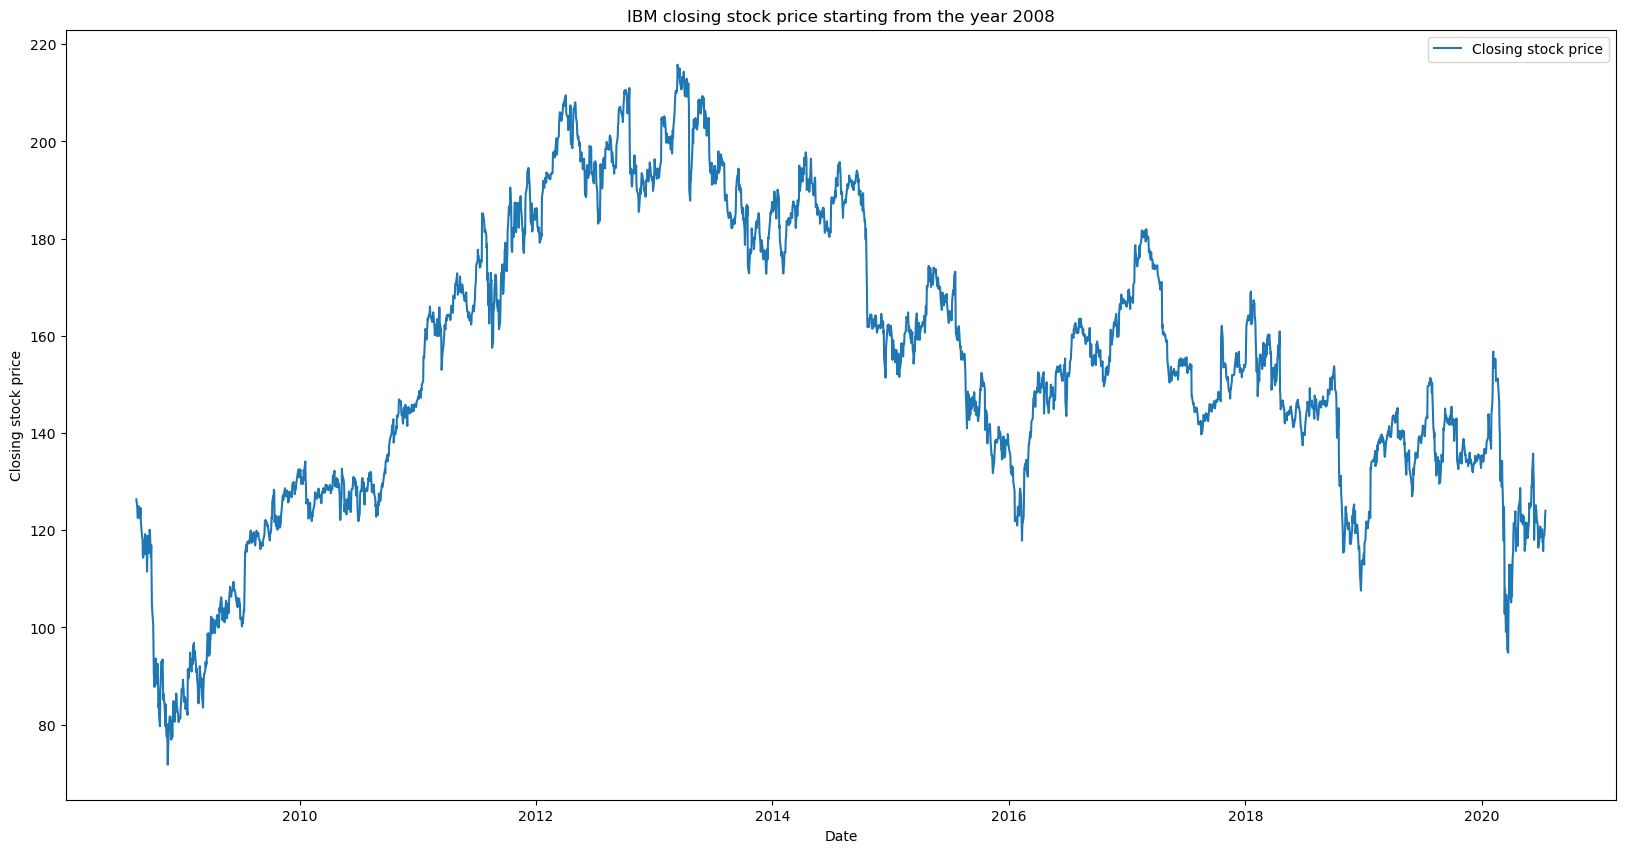

In [13]:
plt.figure(figsize=figsize)
sns.lineplot(data=ibm_stock_df['Close'], label='Closing stock price')
plt.xlabel('Date')
plt.ylabel('Closing stock price')
plt.title('IBM closing stock price starting from the year 2008')
plt.legend()

The graph below shows the monthly trend for closing price of IBM stock data from 2008 to 2020.

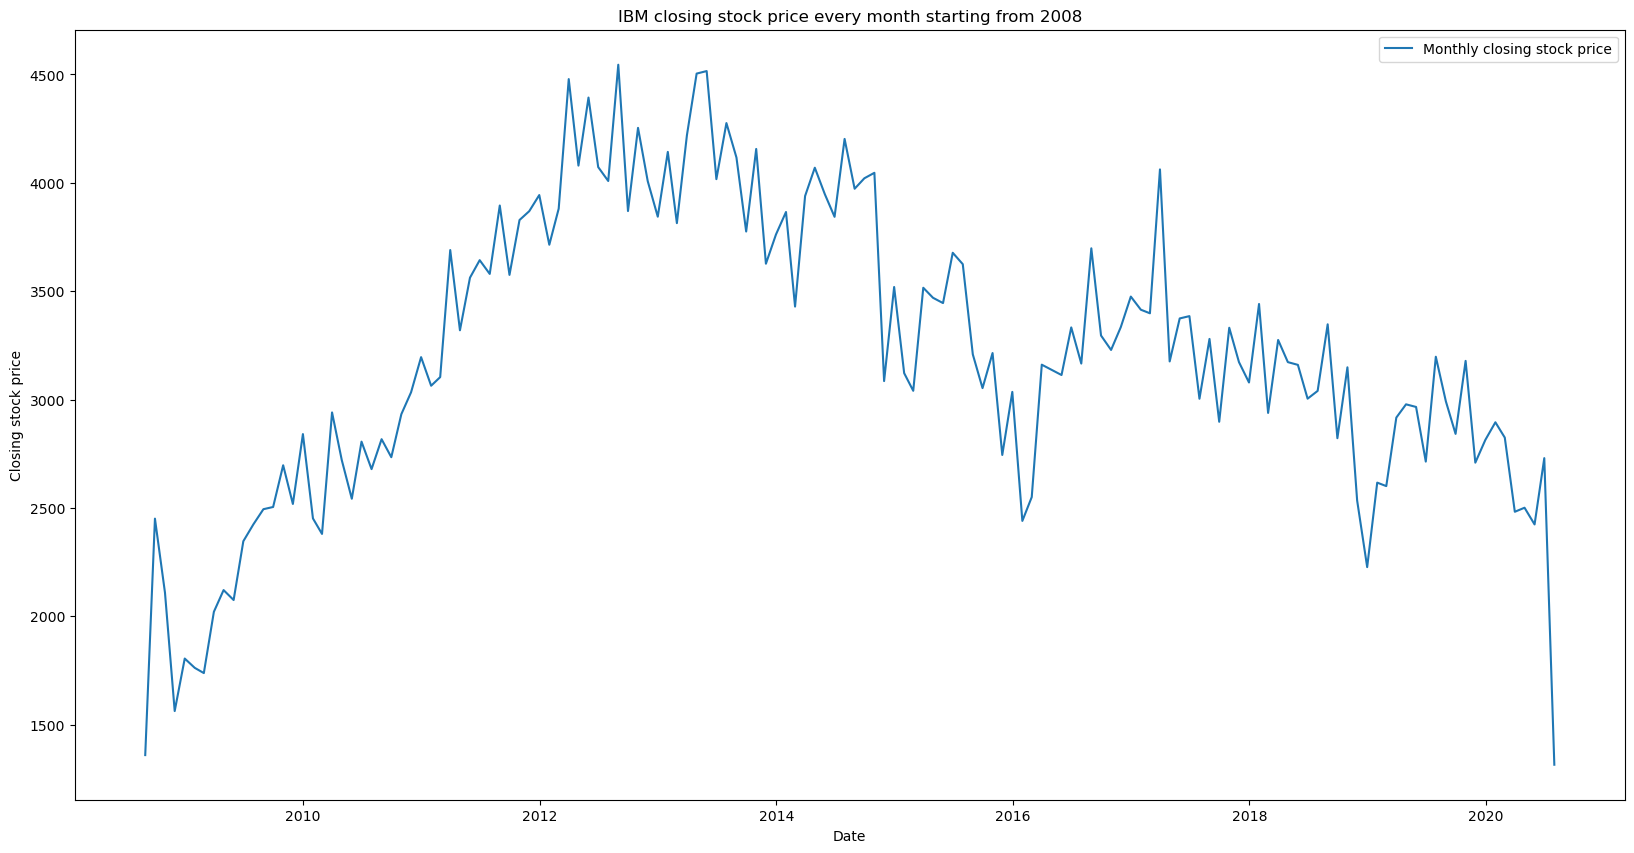

In [14]:
plt.figure(figsize=figsize)
sns.lineplot(data=ibm_stock_df['Close'].resample('M').sum(), label='Monthly closing stock price')
plt.xlabel('Date')
plt.ylabel('Closing stock price')
plt.title('IBM closing stock price every month starting from 2008')
plt.legend()

As observed in the graph below, the given data is non-stationery with random upward and downward trends. The data represented is the number of shares traded for IBM each day.

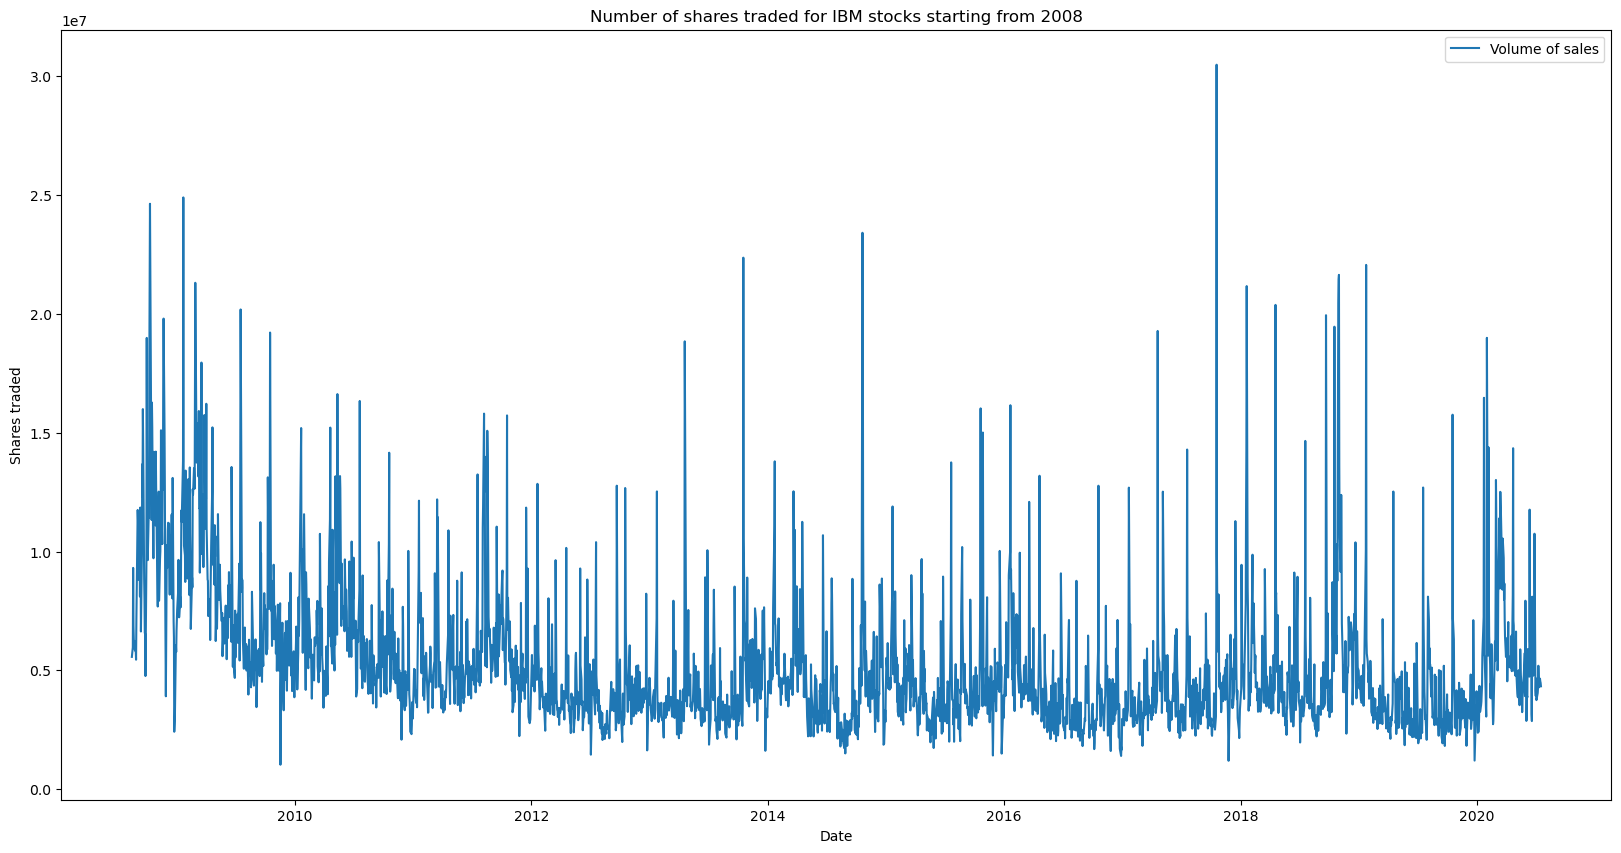

In [15]:
plt.figure(figsize=figsize)
sns.lineplot(data=ibm_stock_df['Volume'], label='Volume of sales')
plt.xlabel('Date')
plt.ylabel('Shares traded')
plt.title('Number of shares traded for IBM stocks starting from 2008')
plt.legend()

The graph below shows the monthly trend for number of shares traded, IBM stock data from 2008 to 2020.

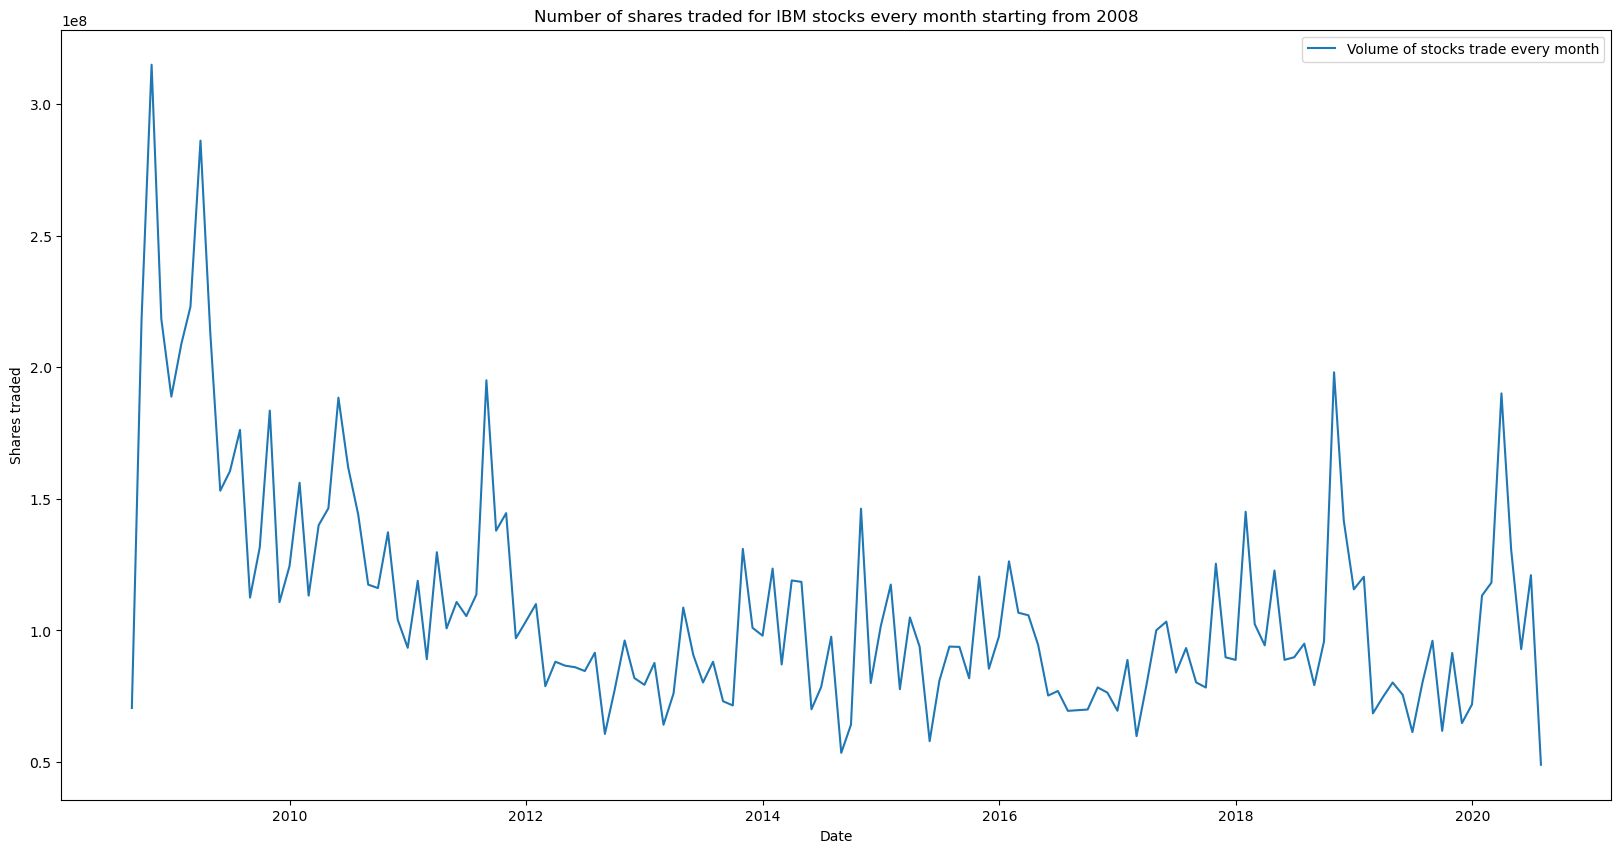

In [16]:
plt.figure(figsize=figsize)
sns.lineplot(data=ibm_stock_df['Volume'].resample('M').sum(), label='Volume of stocks trade every month')
plt.xlabel('Date')
plt.ylabel('Shares traded')
plt.title('Number of shares traded for IBM stocks every month starting from 2008')
plt.legend()

The lag plot below suggests the correlation measure in the dataset. A positive upward trend indicates a positive autocorrelation which can be verified in the ACF plot. <br>
We plot the graphs for lag values of 1, 5, 50, 100. As we increase the lag value, the randomness in the correlation increases. This suggests that values are correlated to recent values than past values.

Text(0.5, 1.0, 'IBM Autocorrelation plot (lag = 100)')

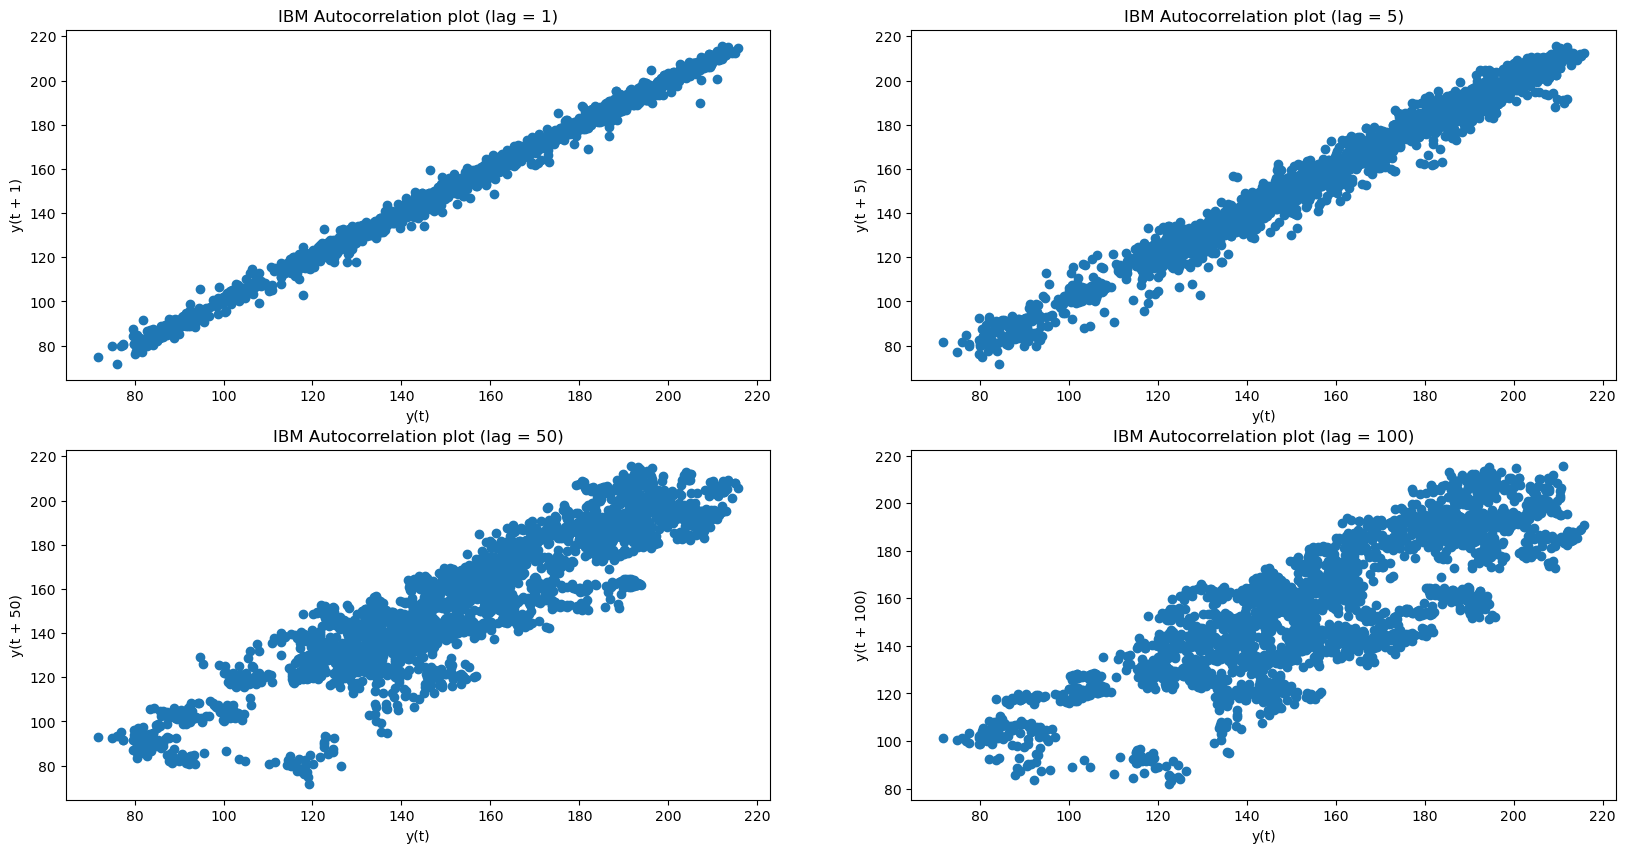

In [17]:
fig = plt.figure(figsize=[20,10])
ax1 = fig.add_subplot(221)
lag_plot(ibm_stock_df['Close'], lag=1, ax=ax1)
plt.title('IBM Autocorrelation plot (lag = 1)')

ax2 = fig.add_subplot(222)
lag_plot(ibm_stock_df['Close'], lag=5, ax=ax2)
plt.title('IBM Autocorrelation plot (lag = 5)')

ax3 = fig.add_subplot(223)
lag_plot(ibm_stock_df['Close'], lag=50, ax=ax3)
plt.title('IBM Autocorrelation plot (lag = 50)')

ax4 = fig.add_subplot(224)
lag_plot(ibm_stock_df['Close'], lag=100, ax=ax4)
plt.title('IBM Autocorrelation plot (lag = 100)')

A difference d = 1 does not indicate any type of correlation for lag value 1. We can observe that the plot below is mostly randomized.

Text(0.5, 1.0, 'IBM Autocorrelation plot (d = 1, lag = 1)')

<Figure size 2000x1000 with 0 Axes>

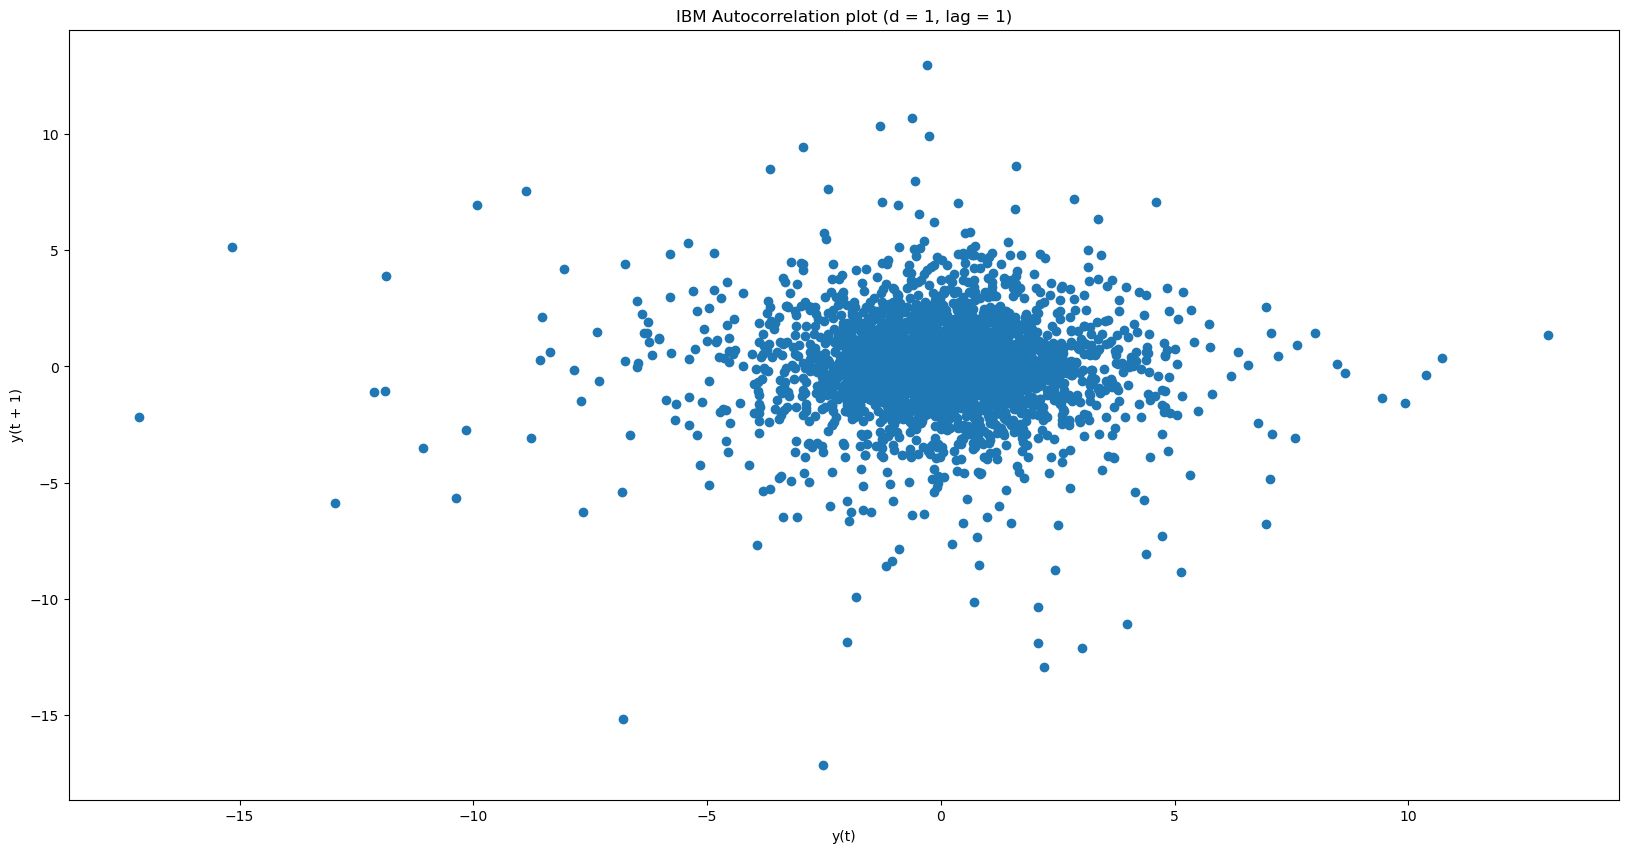

In [18]:
fig = plt.figure(figsize=figsize)
plt.figure(figsize=figsize)
lag_plot((ibm_stock_df['Close'] - ibm_stock_df['Close'].shift(1)), lag=1)
plt.title('IBM Autocorrelation plot (d = 1, lag = 1)')

In [19]:
# Code snippet taken from https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    """
    Function to test stationarity in time series data
    """

    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize=figsizeBig)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [20]:
def non_stationary_plot(label):
  fig = plt.figure(figsize=[20,10])
  ax1 = fig.add_subplot(221)
  fig = sm.graphics.tsa.plot_acf(ibm_stock_df[label].iloc[13:], lags=1000, ax=ax1)
  plt.xlabel('Number of Lags (1000)')
  plt.ylabel('Correlation coefficient')

  ax2 = fig.add_subplot(222)
  fig = sm.graphics.tsa.plot_acf(ibm_stock_df[label].iloc[13:], lags=100, ax=ax2)
  plt.xlabel('Number of Lags (100)')
  plt.ylabel('Correlation coefficient')

  ax3 = fig.add_subplot(223)
  fig = sm.graphics.tsa.plot_pacf(ibm_stock_df[label].iloc[13:], lags=1000, ax=ax3)
  plt.xlabel('Number of Lags (1000)')
  plt.ylabel('Correlation coefficient')

  ax3 = fig.add_subplot(224)
  fig = sm.graphics.tsa.plot_pacf(ibm_stock_df[label].iloc[13:], lags=100, ax=ax3)
  plt.xlabel('Number of Lags (100)')
  plt.ylabel('Correlation coefficient')

In [21]:
def stationary_plot(label):
  fig = plt.figure(figsize=figsize)
  ax1 = fig.add_subplot(211)
  fig = sm.graphics.tsa.plot_acf((ibm_stock_df[label] - ibm_stock_df[label].shift(1)).iloc[13:], lags=100, ax=ax1)
  plt.xlabel('Number of Lags (100)')
  plt.ylabel('Correlation coefficient')

  ax2 = fig.add_subplot(212)
  fig = sm.graphics.tsa.plot_pacf((ibm_stock_df[label] - ibm_stock_df[label].shift(1)).iloc[13:], lags=100, ax=ax2)
  plt.xlabel('Number of Lags (100)')
  plt.ylabel('Correlation coefficient')

Plotting ACF and PACF on **non stationary** values

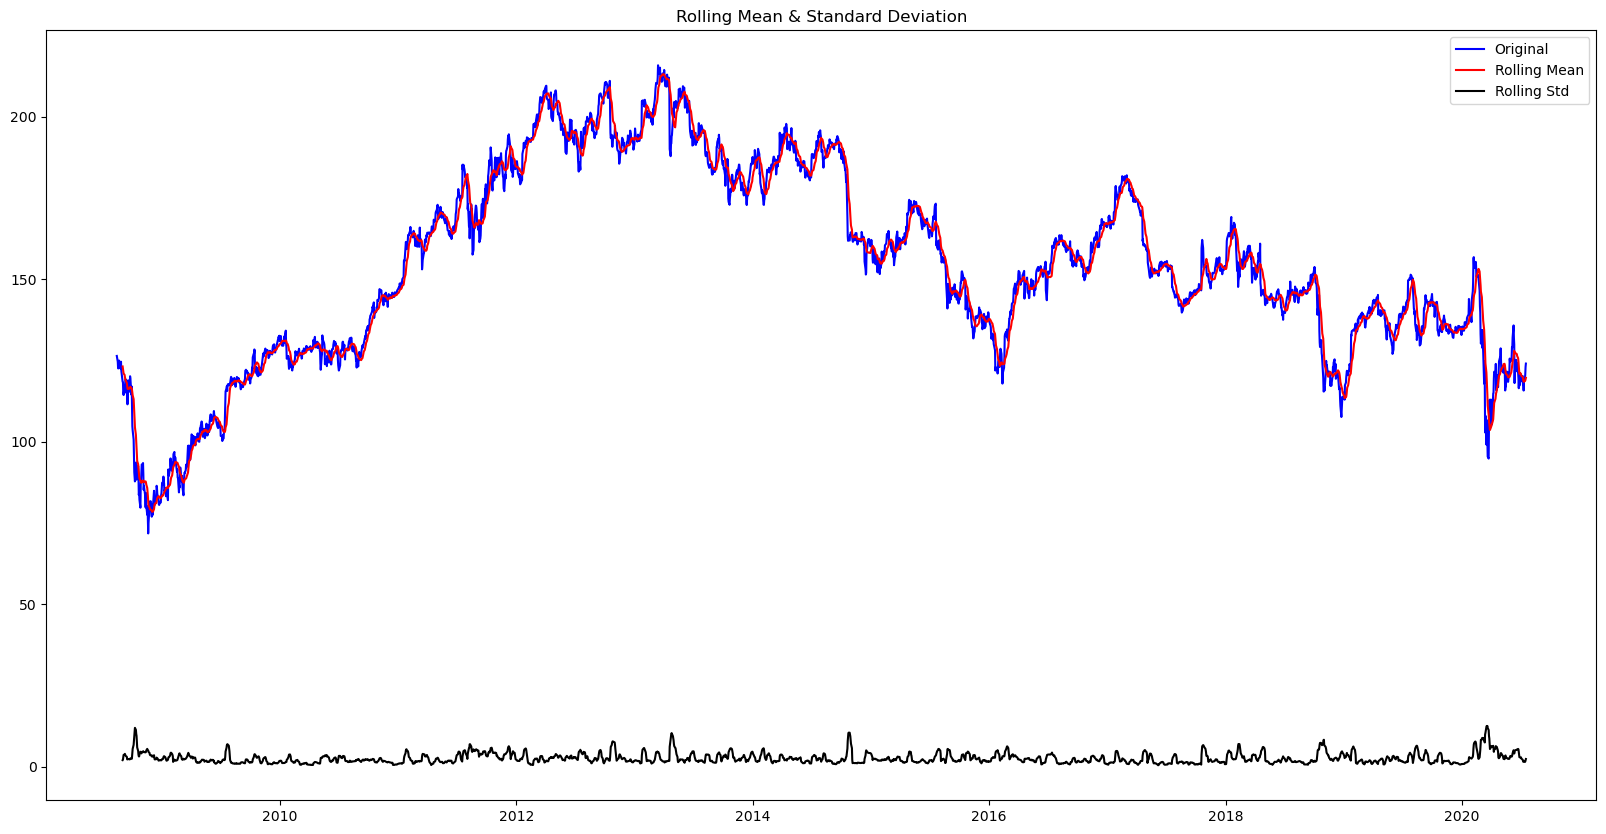

Results of Dickey-Fuller Test:
Test Statistic                   -1.910841
p-value                           0.326979
#Lags Used                       10.000000
Number of Observations Used    2989.000000
Critical Value (1%)              -3.432540
Critical Value (5%)              -2.862507
Critical Value (10%)             -2.567285
dtype: float64


In [22]:
test_stationarity(ibm_stock_df['Close'].dropna(inplace=False))

The degree of autocorrelation is an important factor in constructing an ARIMA model. <br>
The correlation in a lag plot is a point in the ACF plot. The first autocorrelation plot uses 100 lags to determine the correlation decay. Since there is no difference in decay observed, we increase the number of lags to 1000. <br>
As we can see the second autocorrelation plot has a very slow decay. This suggests that the current stock prices are more correlated to recent values than values in the past. To better confirm the findings we need a PACF plot.<br>
A partial autocorrelation is the amount of correlation between a variable and a lag of itself that is not explained by correlations at all lower-order-lags. The PACF plot below has a significant spike at lag 1, this means that all the higher-order autocorrelations are effectively explained by the lag 1 autocorrelation. This can be a useful measure to indicate p,d,q values for our ARIMA model. <br>
However, this is not a very accurate measure as our data is not stationary.

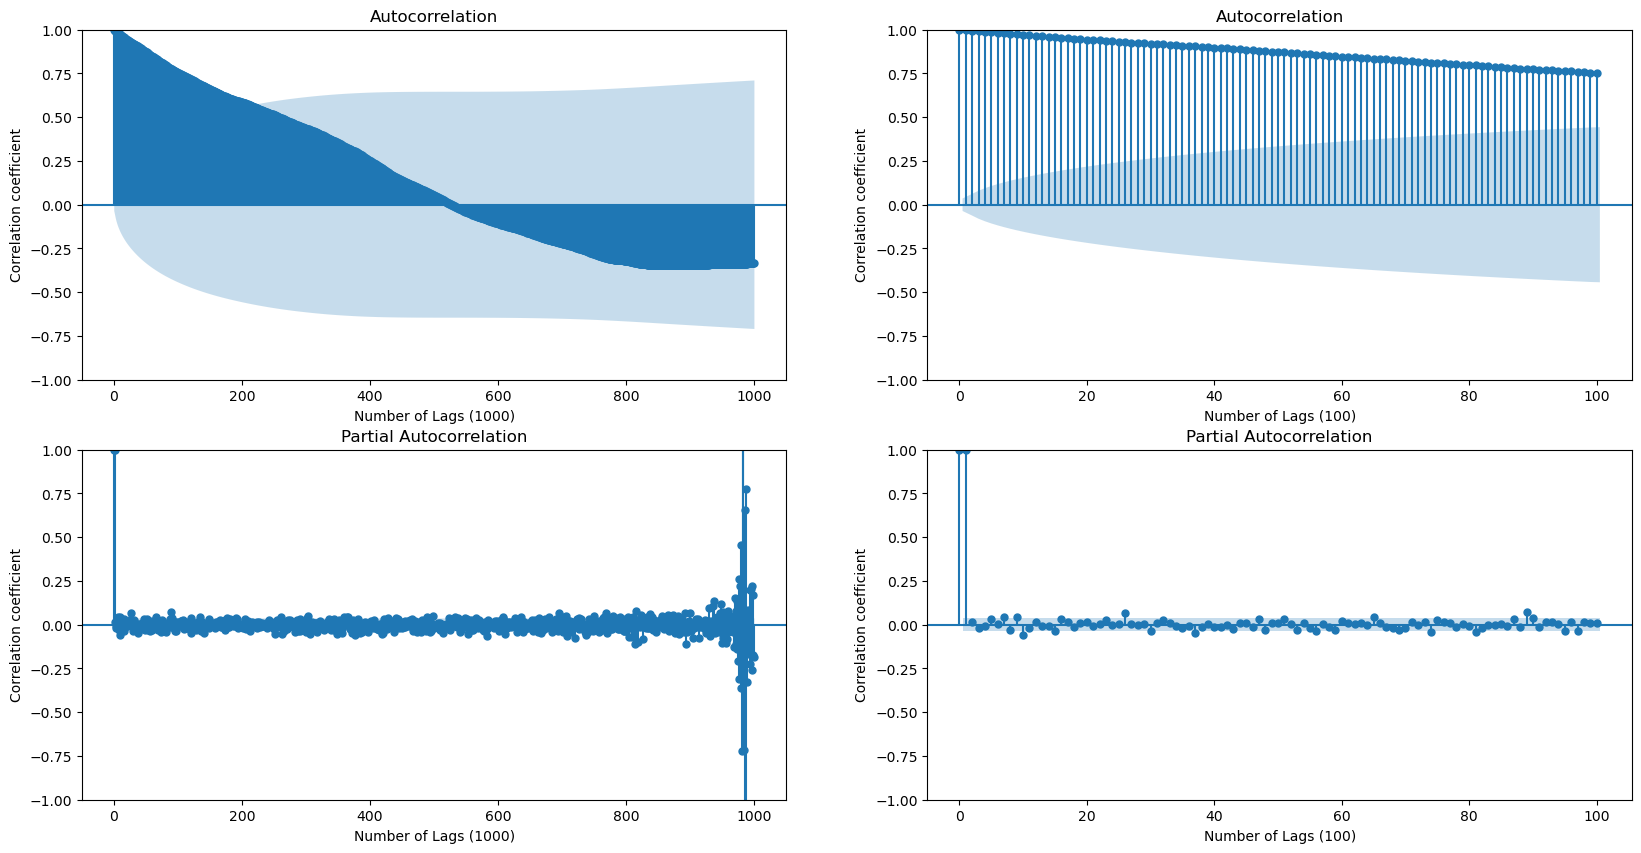

In [23]:
non_stationary_plot('Close')

Plotting ACF and PACF on **stationary** values

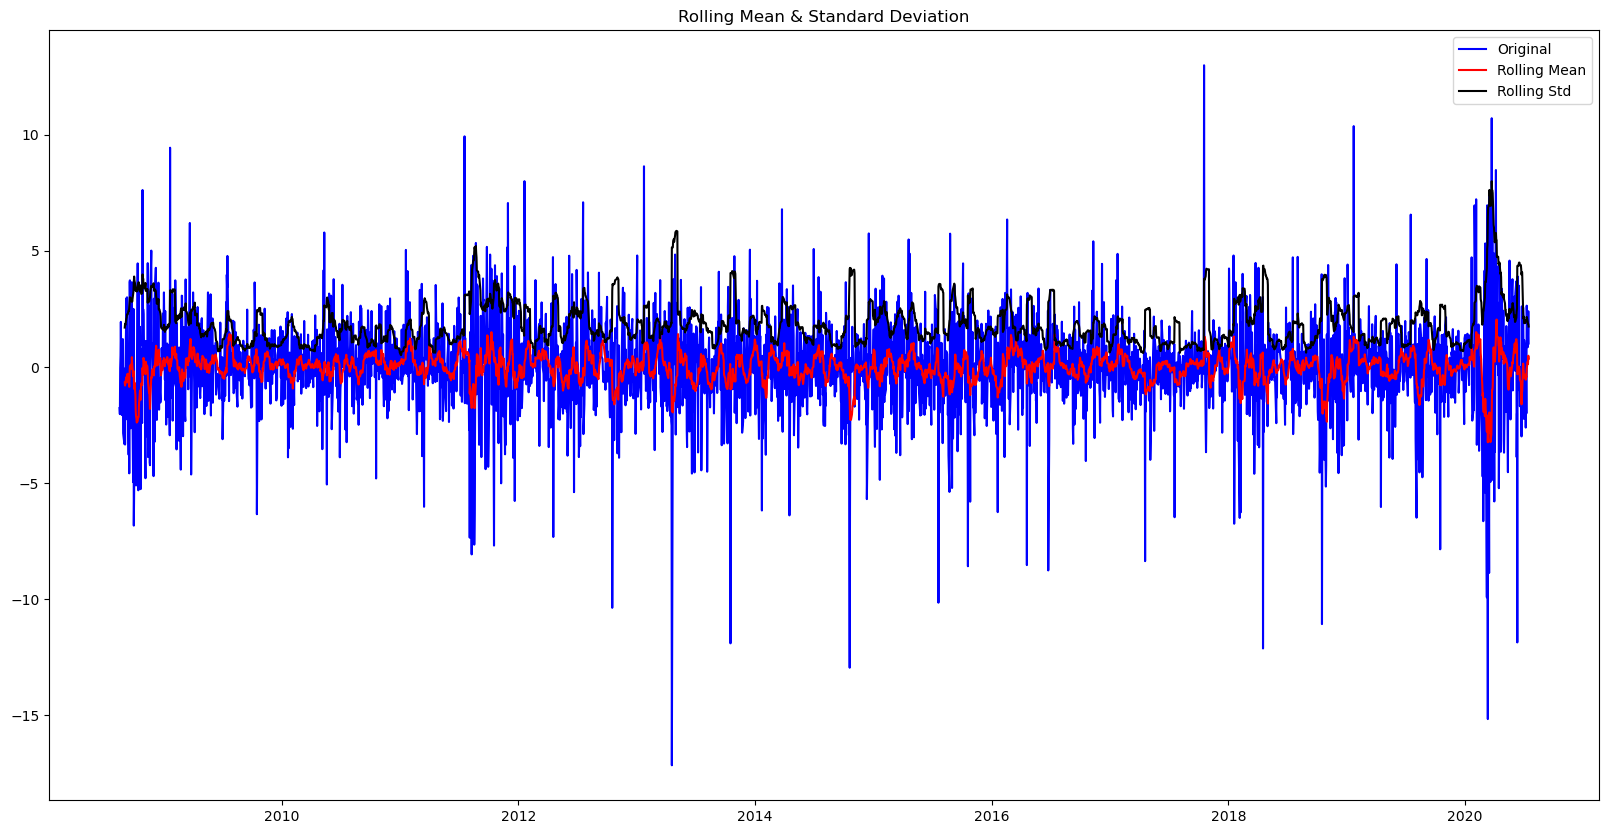

Results of Dickey-Fuller Test:
Test Statistic                -1.696664e+01
p-value                        9.223888e-30
#Lags Used                     9.000000e+00
Number of Observations Used    2.989000e+03
Critical Value (1%)           -3.432540e+00
Critical Value (5%)           -2.862507e+00
Critical Value (10%)          -2.567285e+00
dtype: float64


In [24]:
test_stationarity((ibm_stock_df['Close'] - ibm_stock_df['Close'].shift(1)).dropna(inplace=False))

ARIMA models are required to work on stationary data to make better predictions. An uptrend or a downtrend underestimates or overestimates the mean and variance values. <br>
To convert the data to a stationary series we use the difference term (d) to calculate differences in the data columns. <br>
In the first autocorrelation plot, we use a difference of 1 on the closing stock price column. We can see that the coefficient at lag 1 is very high but after that, it's much less leading to a stationary series. <br>
As a rule of thumb if there is a significant spike in pacf plot at lag-k followed by a steep decrease in the correlation is usually an indication of an AR-1 model. <br>
The plots below suggest an ARIMA model with p-1, difference d-1, and moving average q-0.

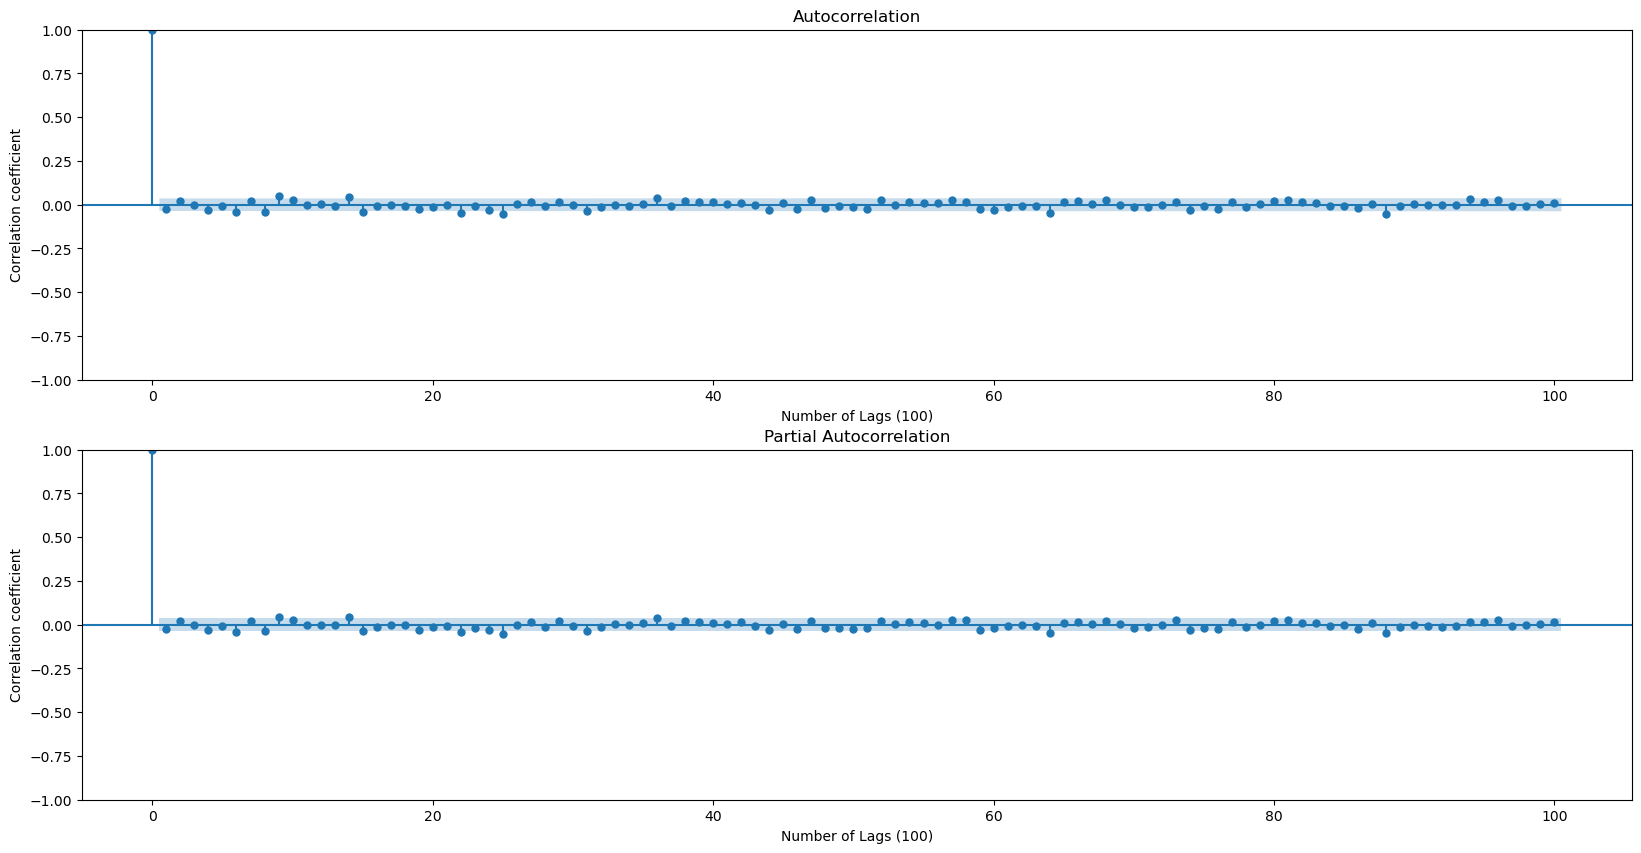

In [25]:
stationary_plot('Close')

#### 3. Preprocess the dataset for training

In [26]:
len(ibm_stock_df)

3000

In [27]:
ibm_stock_df.drop_duplicates(inplace=True)
len(ibm_stock_df)

3000

In [28]:
np.where(pd.isnull(ibm_stock_df))

(array([], dtype=int64), array([], dtype=int64))

In [29]:
train_data, test_data = ibm_stock_df[0:int(len(ibm_stock_df)*0.8)], ibm_stock_df[int(len(ibm_stock_df)*0.8):]

### Part II: Classical time series forecasting methods

#### 1. Choose the features and targets in the dataset.

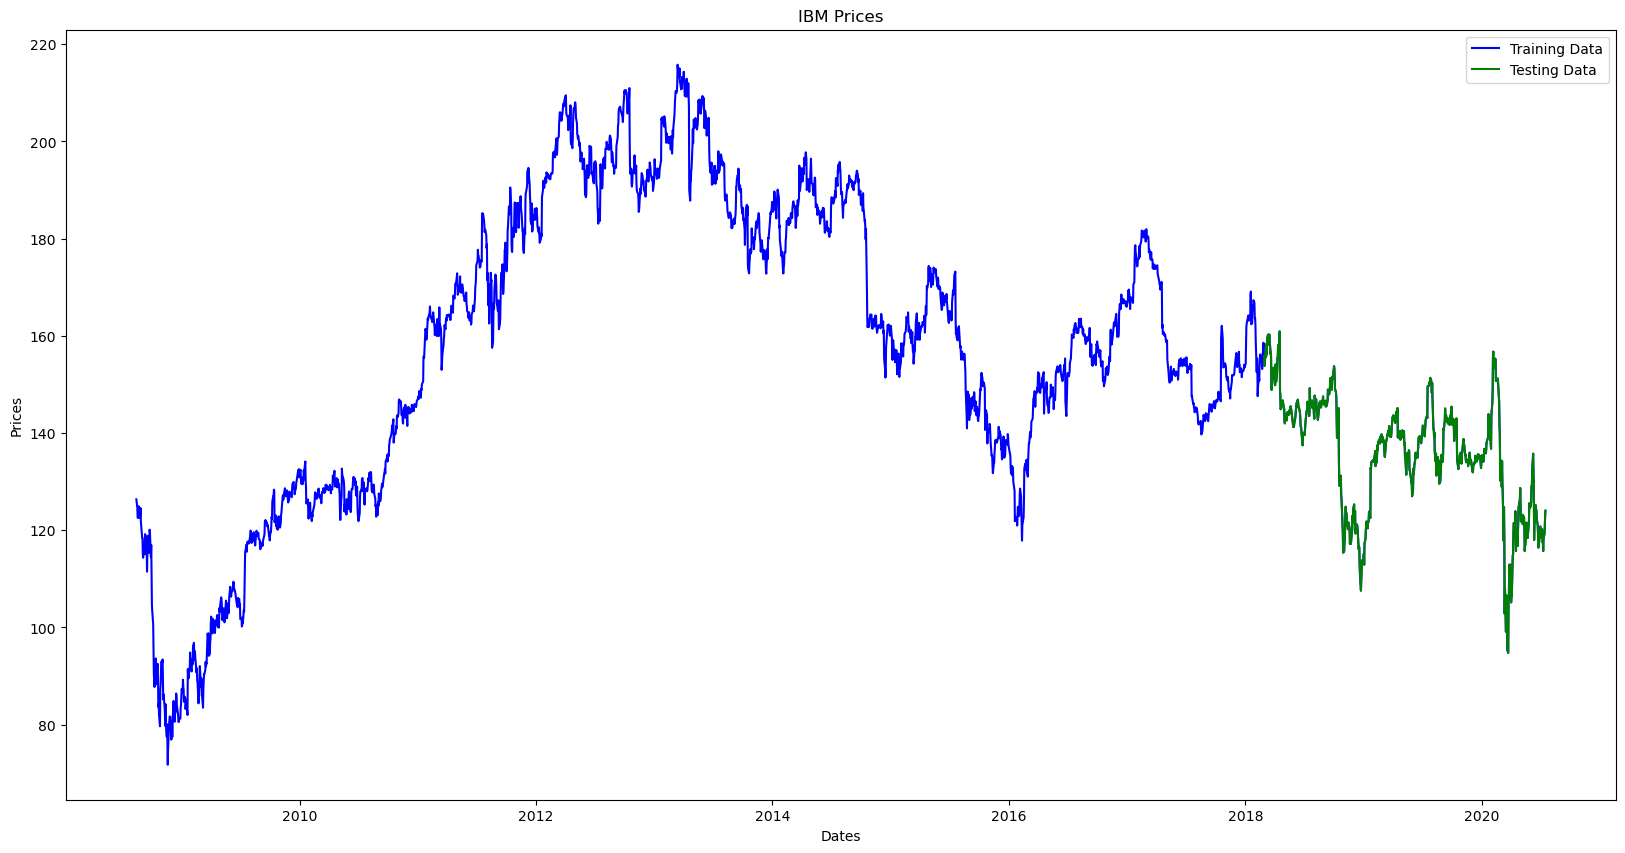

In [30]:
plt.figure(figsize=figsize)
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(ibm_stock_df['Close'], 'blue', label='Training Data')
plt.plot(test_data['Close'], 'green', label='Testing Data')
plt.legend()

#### 2. Apply statistical algorithms to forecast the values on different setups.

**Non seasonal ARIMA model (p,d,q) - Rolling forecast**

ARIMA models can give good results if applied on short time predictions. In the model below, we predict stock price data every day using the training data model and plot the difference between the actual data and test data.

In [31]:
train_ar = train_data['Close'].values
test_ar = test_data['Close'].values

A rolling forecast can be performed by re-creating the ARIMA model for every new observation that is added.

In [32]:
history = [x for x in train_ar]
predictions = list()

for t in range(len(test_ar)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test_ar[t])

In [33]:
msearima = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % msearima)

Testing Mean Squared Error: 6.100


In [34]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2999
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6489.383
Date:                Wed, 07 Feb 2024   AIC                          12982.767
Time:                        15:25:56   BIC                          12994.778
Sample:                             0   HQIC                         12987.087
                               - 2999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0233      0.013     -1.761      0.078      -0.049       0.003
sigma2         4.4427      0.055     80.418      0.000       4.334       4.551
Ljung-Box (L1) (Q):                   0.00   Jarque-

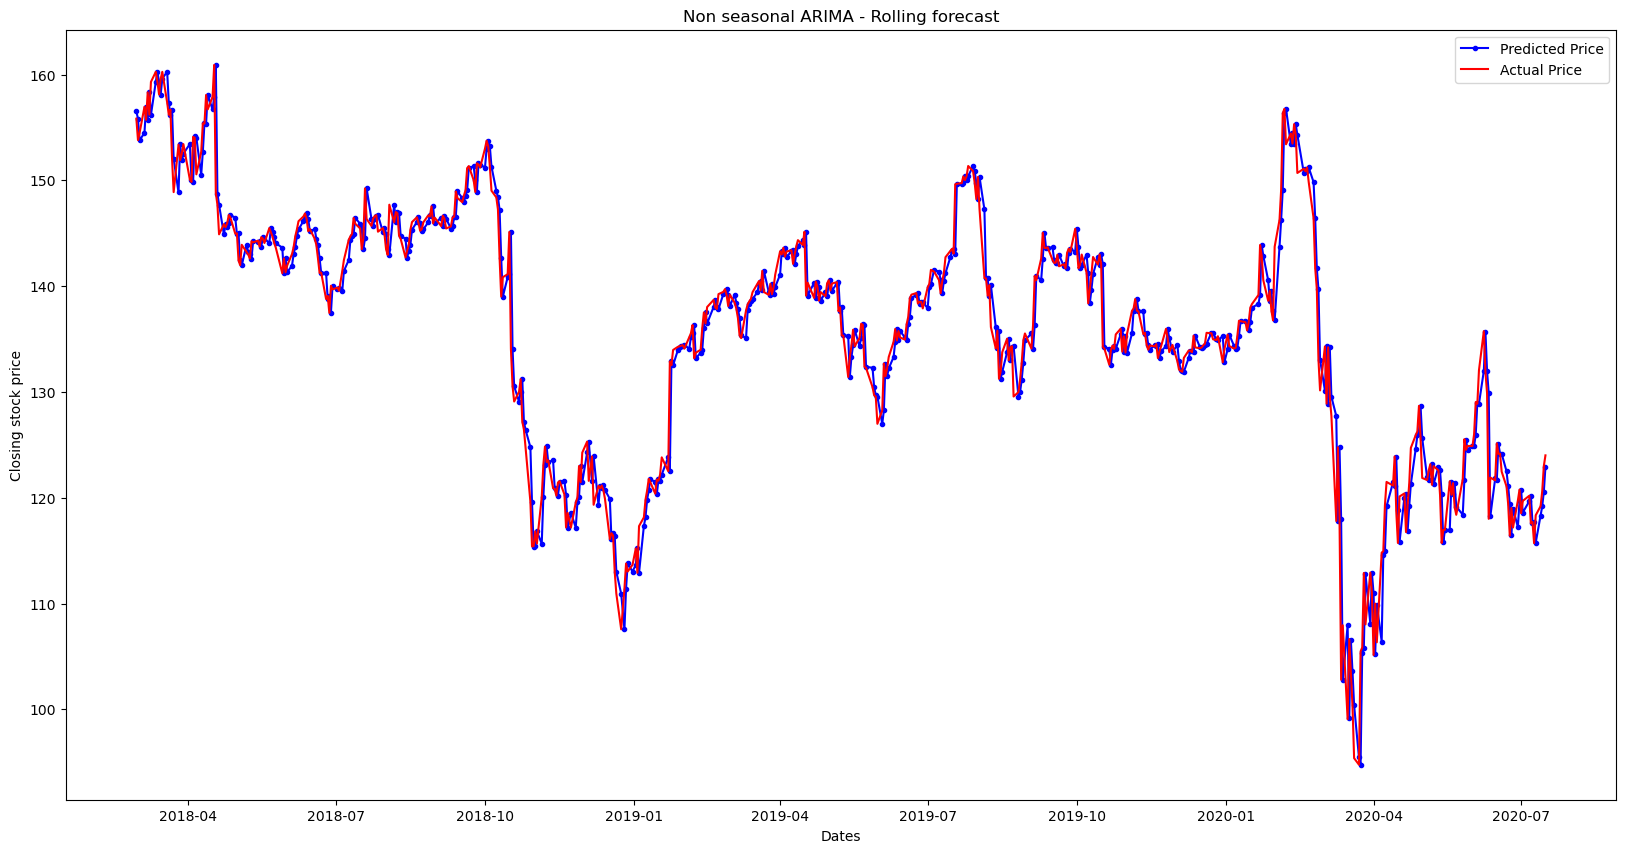

In [35]:
plt.figure(figsize=figsize)
plt.plot(test_data.index, predictions, color='blue', marker='.', label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title('Non seasonal ARIMA - Rolling forecast')
plt.xlabel('Dates')
plt.ylabel('Closing stock price')
plt.legend()

**Holt Winter’s Exponential Smoothing (HWES) - Rolling forecast** <br>

Considers seasonality and trend both into account.


In [36]:
history = [x for x in train_ar]
predictions = list()

for t in range(len(test_data)):
    model = ExponentialSmoothing(history, trend="add", seasonal="add", seasonal_periods=5)
    model_fit = model.fit()
    yhat = model_fit.forecast()
    predictions.append(yhat[0])
    history.append(test_ar[t])

In [37]:
mseholt = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % mseholt)

Testing Mean Squared Error: 6.113


In [38]:
print(model_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 2999
Model:             ExponentialSmoothing   SSE                          13311.905
Optimized:                         True   AIC                           4487.649
Trend:                         Additive   BIC                           4541.704
Seasonal:                      Additive   AICC                          4487.738
Seasonal Periods:                     5   Date:                 Wed, 07 Feb 2024
Box-Cox:                          False   Time:                         15:30:31
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9774411                alpha                 True
smoothing_trend          

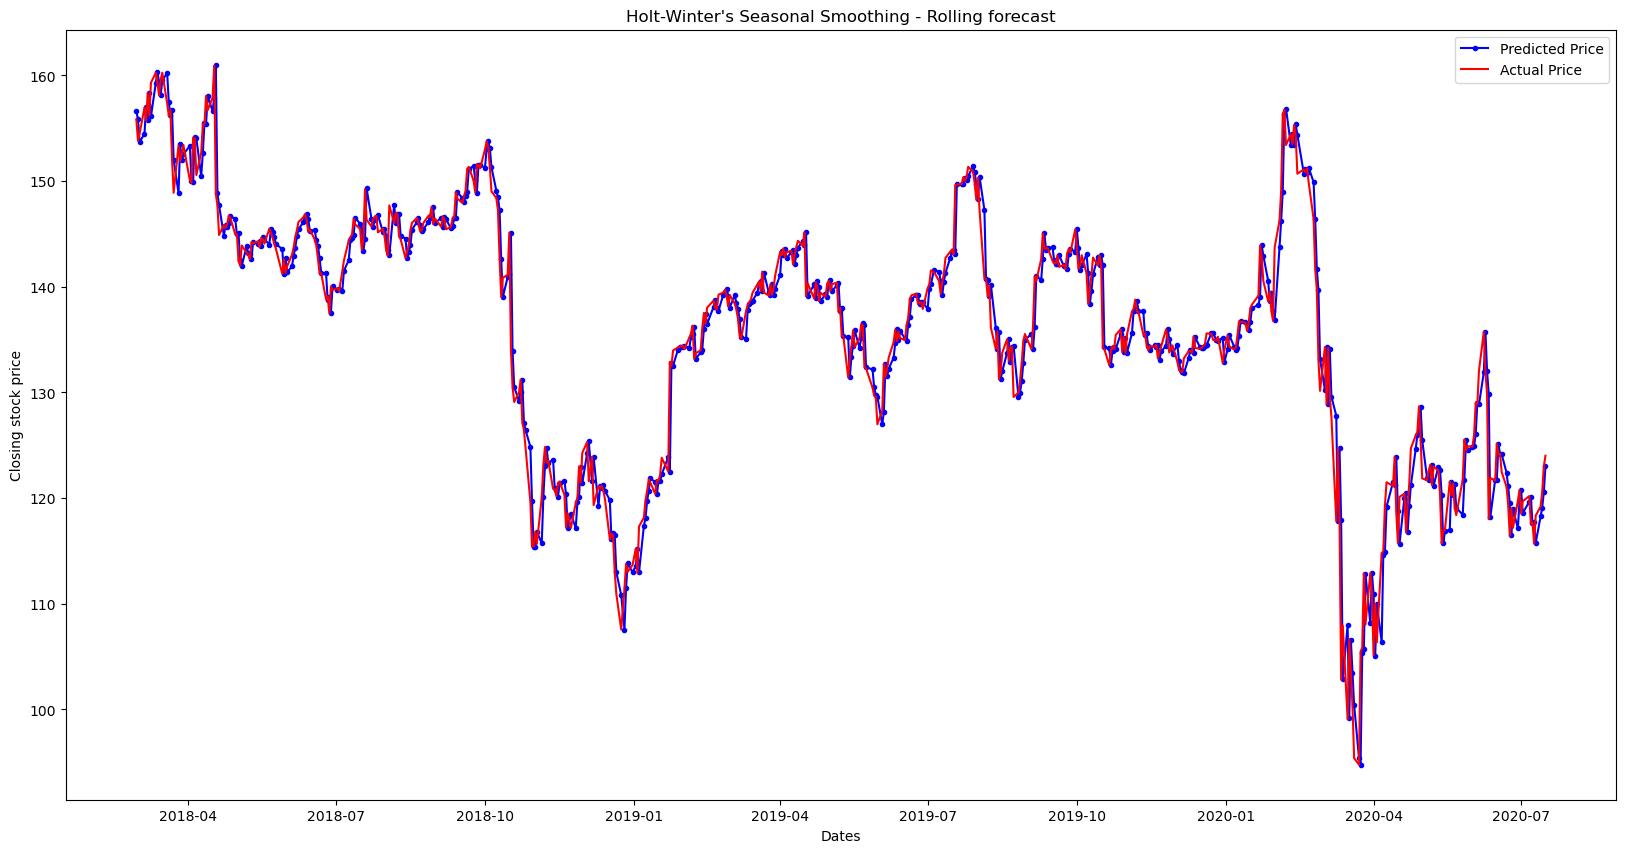

In [39]:
plt.figure(figsize=figsize)
plt.plot(test_data.index, predictions, color='blue', marker='.', label="Predicted Price")
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title("Holt-Winter's Seasonal Smoothing - Rolling forecast")
plt.xlabel('Dates')
plt.ylabel('Closing stock price')
plt.legend()

**Seasonal ARIMA model (SARIMA)**


We aggregate our data on a monthly basis using a rolling mean and analyze the data using SARIMAX model.


In [40]:
ibm_stock_df['MonthlyClose'] = ibm_stock_df['Close'] - ibm_stock_df['Close'].rolling(12).mean()

In [41]:
ibm_stock_df['MonthlyClose']

Date
2008-08-15         NaN
2008-08-18         NaN
2008-08-19         NaN
2008-08-20         NaN
2008-08-21         NaN
                ...   
2020-07-10   -0.061668
2020-07-13    0.556664
2020-07-14    1.825832
2020-07-15    3.741667
2020-07-16    4.396669
Name: MonthlyClose, Length: 3000, dtype: float64

Plotting ACF and PACF on **non stationary** graph for monthly closing stock price data.

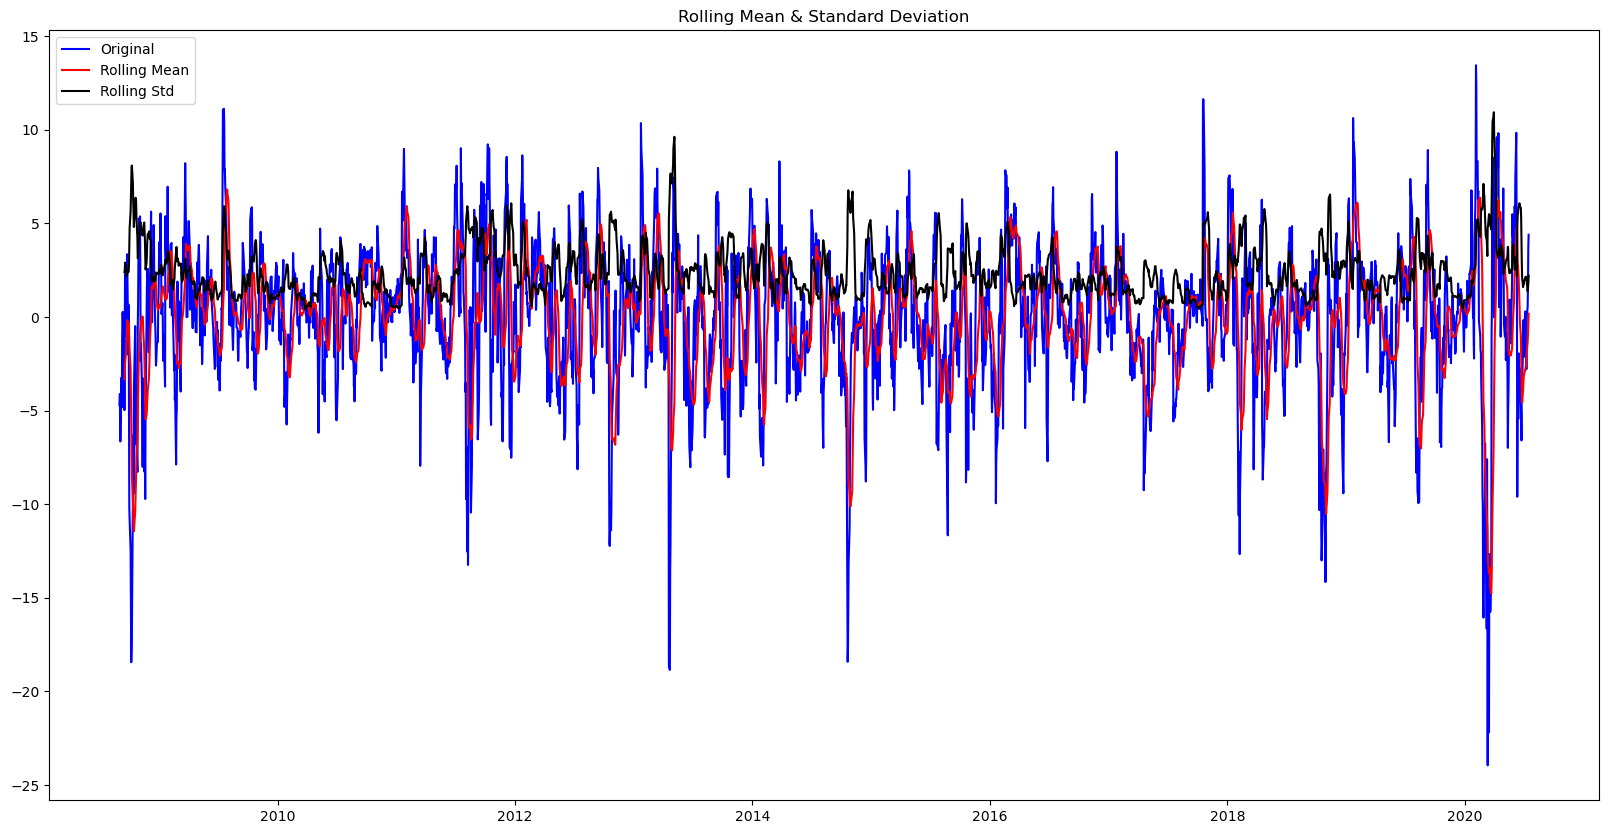

Results of Dickey-Fuller Test:
Test Statistic                -1.299090e+01
p-value                        2.813936e-24
#Lags Used                     1.400000e+01
Number of Observations Used    2.974000e+03
Critical Value (1%)           -3.432551e+00
Critical Value (5%)           -2.862512e+00
Critical Value (10%)          -2.567288e+00
dtype: float64


In [42]:
test_stationarity(ibm_stock_df['MonthlyClose'].dropna(inplace=False))

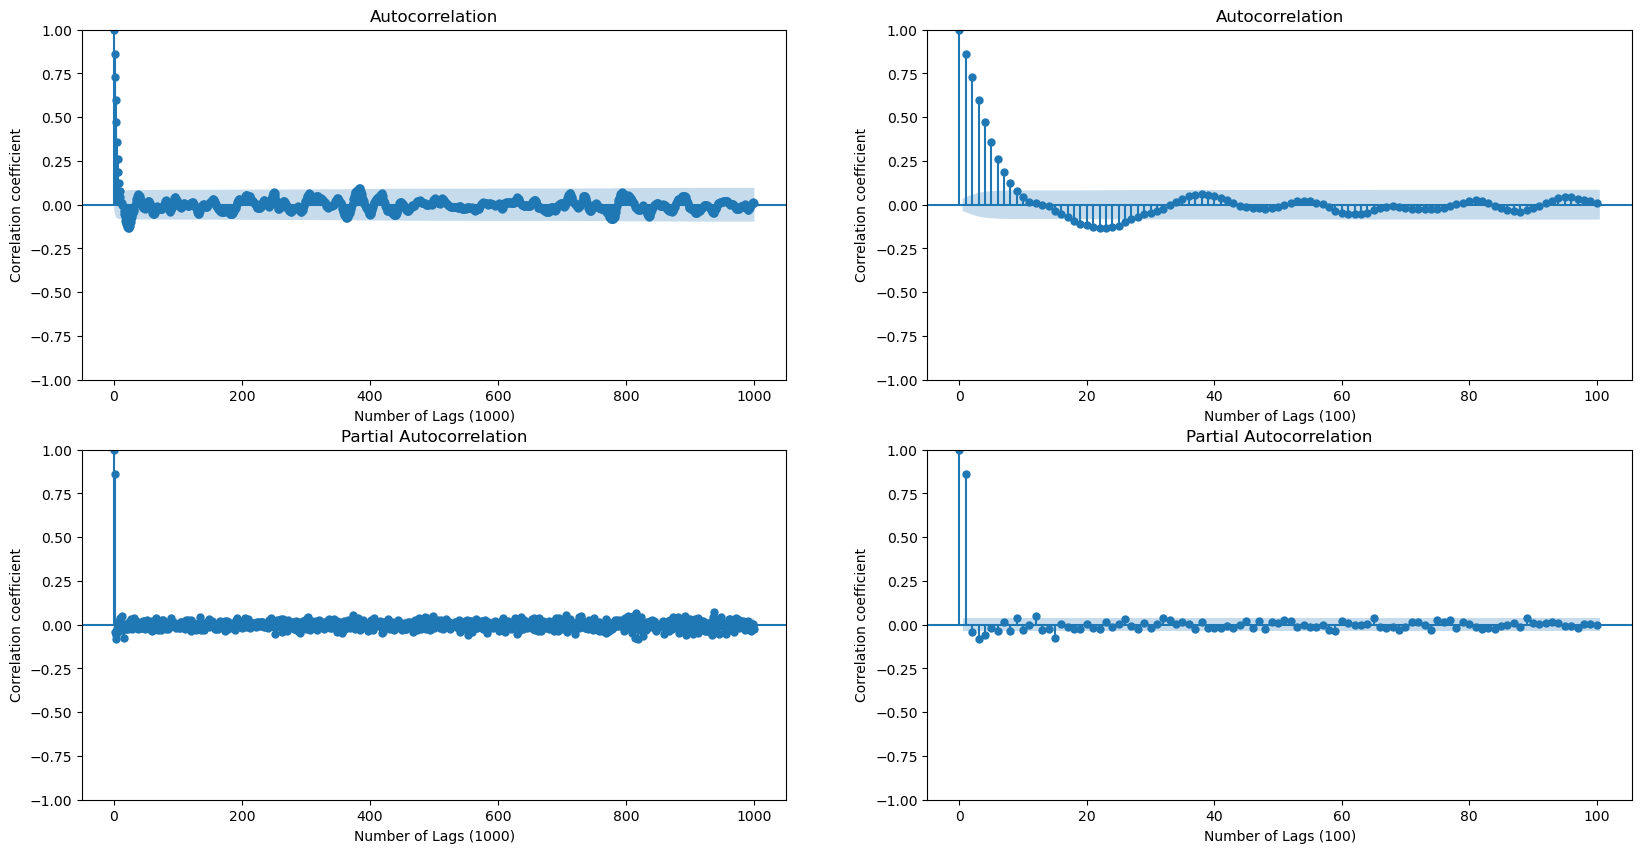

In [43]:
non_stationary_plot('MonthlyClose')

Plotting ACF and PACF on **stationary** graph for monthly closing stock price data.

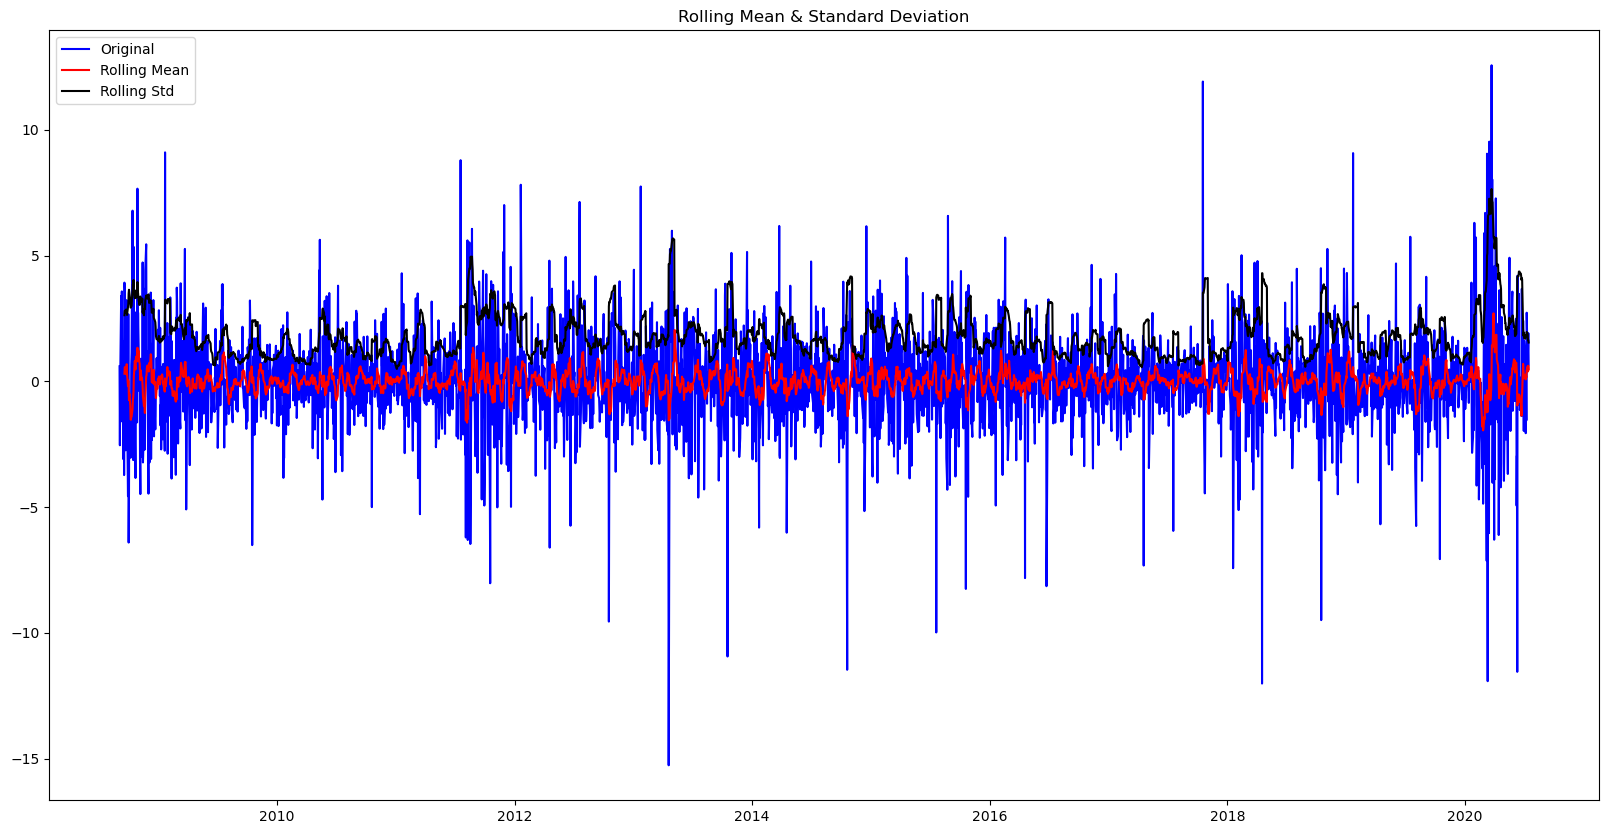

Results of Dickey-Fuller Test:
Test Statistic                -1.598190e+01
p-value                        6.820749e-29
#Lags Used                     2.900000e+01
Number of Observations Used    2.958000e+03
Critical Value (1%)           -3.432563e+00
Critical Value (5%)           -2.862518e+00
Critical Value (10%)          -2.567290e+00
dtype: float64


In [44]:
test_stationarity((ibm_stock_df['MonthlyClose'] - ibm_stock_df['MonthlyClose'].shift(1)).dropna(inplace=False))

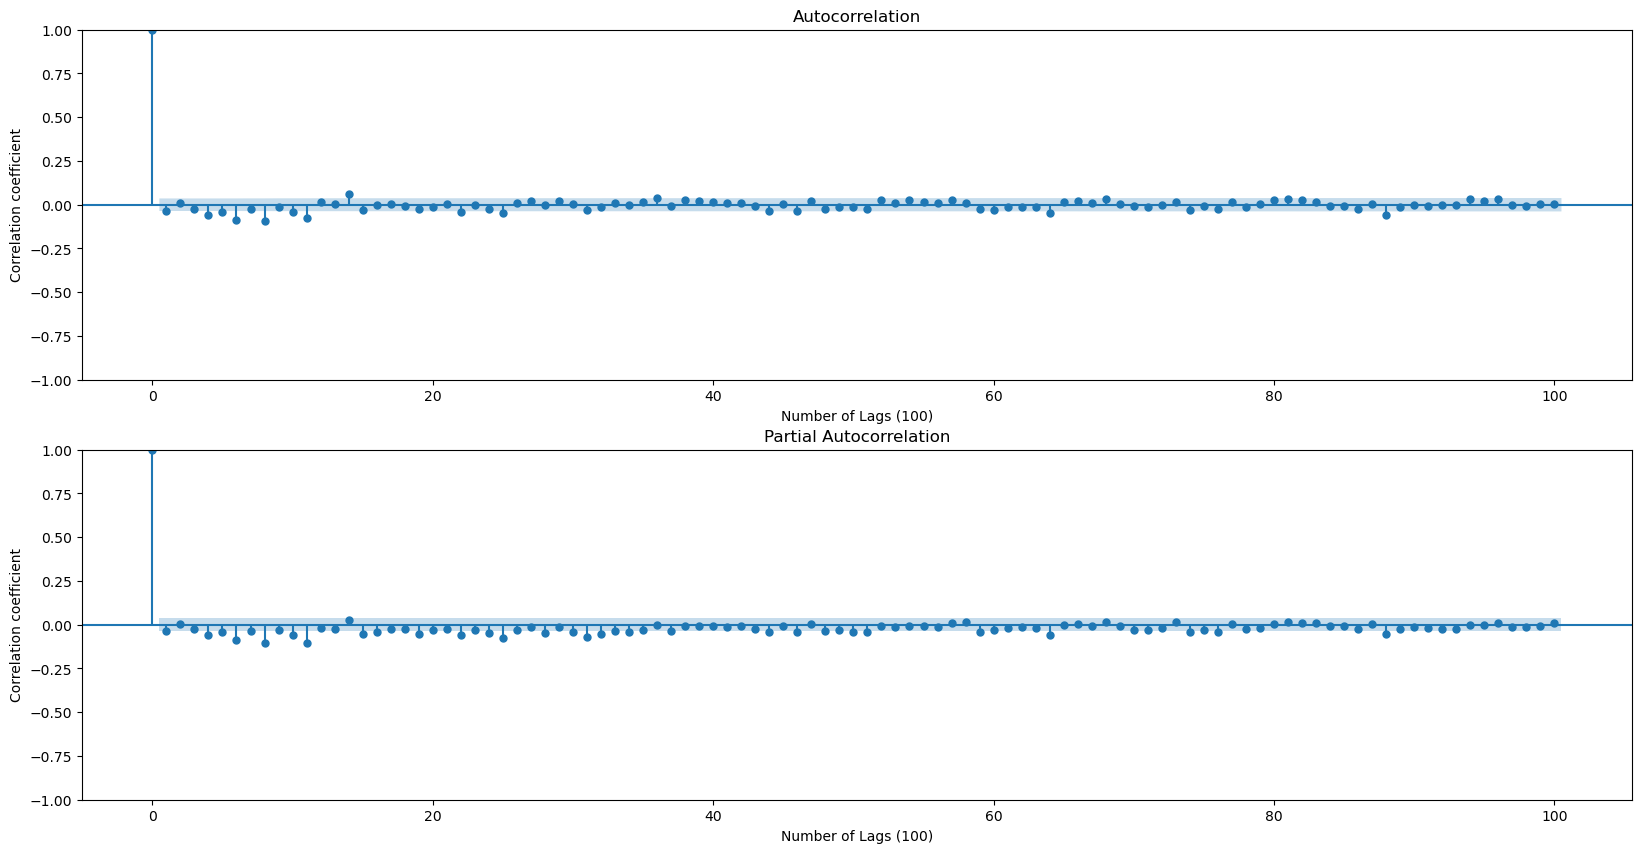

In [45]:
stationary_plot('MonthlyClose')

In [46]:
train_data, test_data = ibm_stock_df[0:int(len(ibm_stock_df)*0.8)], ibm_stock_df[int(len(ibm_stock_df)*0.8):]
train_ar = train_data['MonthlyClose'].values
test_ar = test_data['MonthlyClose'].values

In [47]:
model = SARIMAX(train_ar, order=(0,1,1), seasonal_order=(0,1,1,12))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 2400
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -5045.647
Date:                            Wed, 07 Feb 2024   AIC                          10097.295
Time:                                    15:31:06   BIC                          10114.628
Sample:                                         0   HQIC                         10103.603
                                           - 2400                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0049      0.018      0.275      0.783      -0.030       0.040
ma.S.L12      -0.9925      0.008   

In [48]:
predictions= model_fit.predict(len(train_data), end=len(train_data)+len(test_data)-1)
msesarimax= mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % msesarimax)

Testing Mean Squared Error: 35.166


#### 3. Provide the comparison of the results of different statistical models you have used.

Explanation: As we can observe the results from the graph, we find ARIMA and Holt's method give better results than the SARIMA model. This is because the stock data for IBM is non-seasonal and it results in inaccurate predictions when the seasonality parameter is taken into account (D).

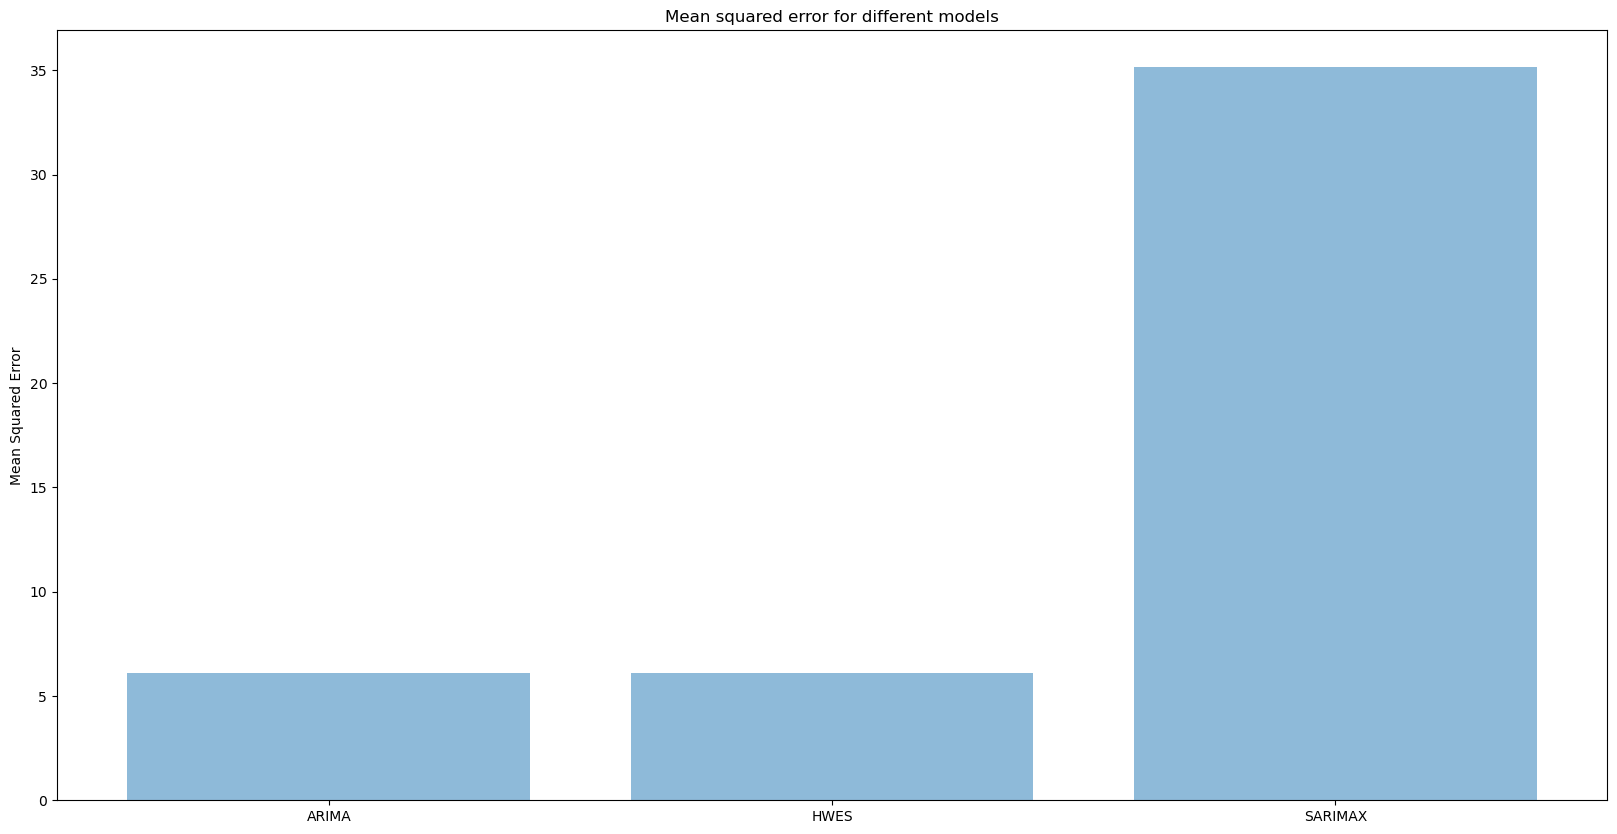

In [49]:
objects = ('ARIMA', 'HWES', 'SARIMAX')
scores = [msearima, mseholt, msesarimax]
plt.figure(figsize=figsize)
plt.bar(objects, scores, align='center', alpha=0.5)
plt.xticks(objects)
plt.ylabel('Mean Squared Error')
plt.title('Mean squared error for different models')
plt.show()

### Part III: Deep learning time series forecasting methods

In [50]:
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [51]:
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = Y[0:p]
    
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
    
    X_test = X[p:]
    Y_test = y[p:]
    
    return X_train, X_test, Y_train, Y_test

In [52]:
WINDOW = 30
EMB_SIZE = 1
STEP = 1
FORECAST = 5

In [53]:
X, Y = [], []
data = ibm_stock_df.loc[:,'Close'].tolist()
for i in range(0, len(data), STEP):
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]
        
        last_close = x_i[WINDOW-1]
        next_close = y_i
        
        if last_close < next_close:
            y_i = [1 , 0]
        else: 
            y_i = [0 , 1]
            
    except Exception as e:
        print(e)
        break
        
    X.append(x_i)
    Y.append(y_i)
X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X]
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

list index out of range


In [54]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2668, 30)
(297, 30)
(2668, 2)
(297, 2)


In [55]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, Dropout
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, ReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from keras.regularizers import l2

Apply RNN-LSTM to predict the share value.

In [59]:
model = Sequential()

model.add(LSTM(units=256, input_shape=(X_train.shape[1], 1),return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=2, activation = "softmax"))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 256)           264192    
                                                                 
 dropout_4 (Dropout)         (None, 30, 256)           0         
                                                                 
 lstm_5 (LSTM)               (None, 30, 128)           197120    
                                                                 
 dropout_5 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_6 (LSTM)               (None, 30, 64)            49408     
                                                                 
 dropout_6 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 32)               

In [63]:
history = model.fit(X_train, Y_train,
                   epochs=40,
                   batch_size=32,validation_data=(X_test, Y_test))

Epoch 1/40
84/84 [==============================] - 6s 68ms/step - loss: 0.2494 - accuracy: 0.5319 - val_loss: 0.2480 - val_accuracy: 0.4781
Epoch 2/40
84/84 [==============================] - 6s 66ms/step - loss: 0.2492 - accuracy: 0.5247 - val_loss: 0.2481 - val_accuracy: 0.5354
Epoch 3/40
84/84 [==============================] - 6s 66ms/step - loss: 0.2490 - accuracy: 0.5240 - val_loss: 0.2466 - val_accuracy: 0.5320
Epoch 4/40
84/84 [==============================] - 6s 66ms/step - loss: 0.2490 - accuracy: 0.5266 - val_loss: 0.2460 - val_accuracy: 0.5354
Epoch 5/40
84/84 [==============================] - 6s 67ms/step - loss: 0.2491 - accuracy: 0.5352 - val_loss: 0.2503 - val_accuracy: 0.5354
Epoch 6/40
84/84 [==============================] - 6s 67ms/step - loss: 0.2504 - accuracy: 0.5139 - val_loss: 0.2484 - val_accuracy: 0.5354
Epoch 7/40
84/84 [==============================] - 6s 67ms/step - loss: 0.2492 - accuracy: 0.5262 - val_loss: 0.2475 - val_accuracy: 0.5421
Epoch 8/40
84

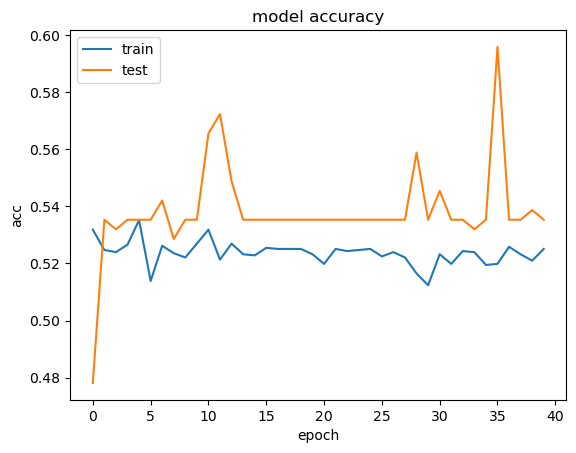

In [64]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

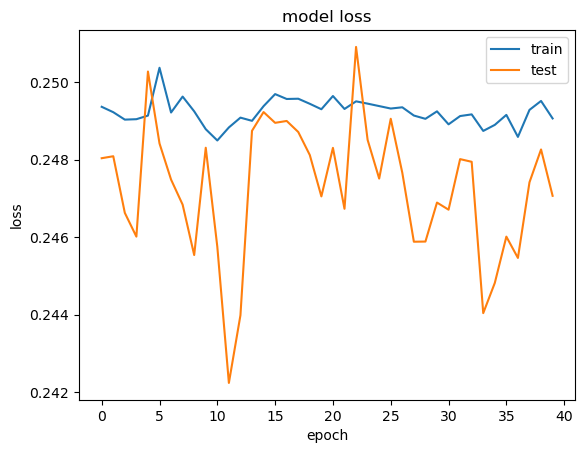

In [65]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

In the model above, kernel weights, bias and activation functions are left to default, with 256,128,64,32 nodes in layers with 40 epochs for the network. Final test accuracy of the model is **52.73**%.

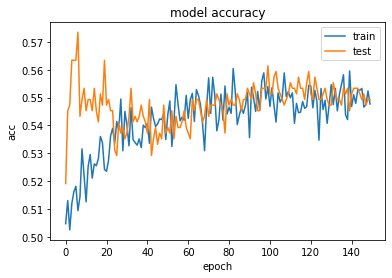

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

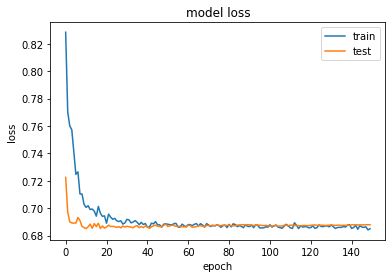

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

In [66]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [67]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2668, 30, 1)
(297, 30, 1)
(2668, 2)
(297, 2)


2. Apply RNN or LSTM architecture to predict the value.

In [68]:
model6 = Sequential()
model6.add(LSTM(units = 32, input_shape = (X_train.shape[1], 1), return_sequences = True))
model6.add(Dropout(0.3))
model6.add(LSTM(units = 16, return_sequences = True))
model6.add(Flatten())
model6.add(Dense(units=2, activation = "softmax"))
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
model6.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 32)            4352      
                                                                 
 dropout_8 (Dropout)         (None, 30, 32)            0         
                                                                 
 lstm_9 (LSTM)               (None, 30, 16)            3136      
                                                                 
 flatten_2 (Flatten)         (None, 480)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 962       
                                                                 
Total params: 8,450
Trainable params: 8,450
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = model6.fit(X_train, Y_train,
                   epochs=10,
                   batch_size=64,
                   verbose=1,
                   validation_data=(X_test, Y_test), 
                    callbacks=[reduce_lr])

Epoch 1/10
42/42 [==============================] - 6s 28ms/step - loss: 0.6931 - accuracy: 0.5157 - val_loss: 0.6791 - val_accuracy: 0.6027 - lr: 0.0010
Epoch 2/10
42/42 [==============================] - 1s 14ms/step - loss: 0.6900 - accuracy: 0.5394 - val_loss: 0.6808 - val_accuracy: 0.6094 - lr: 0.0010
Epoch 3/10
42/42 [==============================] - 1s 14ms/step - loss: 0.6902 - accuracy: 0.5311 - val_loss: 0.6838 - val_accuracy: 0.6162 - lr: 0.0010
Epoch 4/10
42/42 [==============================] - 1s 14ms/step - loss: 0.6897 - accuracy: 0.5304 - val_loss: 0.6811 - val_accuracy: 0.5253 - lr: 0.0010
Epoch 5/10
42/42 [==============================] - 1s 14ms/step - loss: 0.6893 - accuracy: 0.5439 - val_loss: 0.6820 - val_accuracy: 0.5219 - lr: 0.0010
Epoch 6/10
39/42 [==========================>...] - ETA: 0s - loss: 0.6895 - accuracy: 0.5405
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
42/42 [==============================] - 1s 14ms/step - loss

The LSTM model given above gives the highest accuracy among all the models trained so far with **54.34**% . This model has 32 nodes in the first layer and 16 nodes in the second one, with *adam* optimizer and *categorical cross entropy* loss.

The method above is trained only to predict if the stock price of the next day goes up or down. It is a classification problem. Then next approach gives the regression analysis, which predicts the stock price of the next day, where LSTM with one layer is used with 16 nodes.

In [70]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [71]:
train_data, test_data = ibm_stock_df[0:int(len(ibm_stock_df)*0.8)], ibm_stock_df[int(len(ibm_stock_df)*0.8):]

In [72]:
train_data = train_data['Close'].values.reshape(-1,1)
test_data = test_data['Close'].values.reshape(-1,1)

In [73]:
train_data = scaler.fit_transform(train_data)

In [74]:
x_train = train_data[:-1]
y_train = train_data[1:]

In [75]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, 1))

In [76]:
lstm_model = Sequential()
lstm_model.add(LSTM(units = 16, activation = 'relu', input_shape = (None, 1)))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [77]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 16)                1152      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [79]:
history = lstm_model.fit(x_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 2/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0082
Epoch 3/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0068
Epoch 4/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 5/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 6/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 7/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 8/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 9/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 10/50
75/75 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 11/50
75/75 [==============================] - 0s 1ms/step - loss: 9.5222e-04
Epoch 12/50
75/75 [==============================] - 0s 1ms/step - loss: 8.3697e-04
Epoch 13/50
75/75 [======================

In [80]:
ip = test_data
test_data = scaler.transform(test_data)
test = np.reshape(test_data, (test_data.shape[0],1,1))
preds = lstm_model.predict(test)

19/19 [==============================] - 0s 927us/step


In [81]:
preds = scaler.inverse_transform(preds)

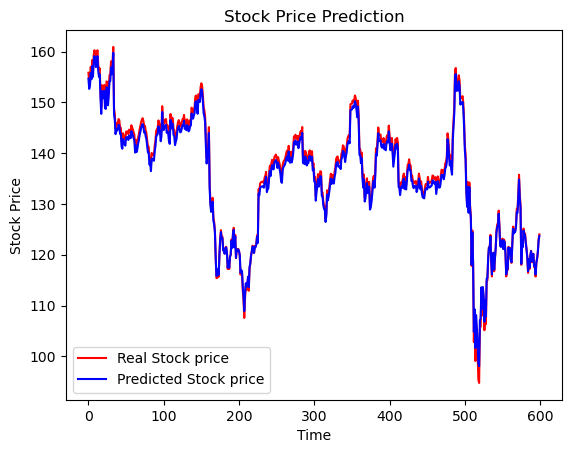

In [82]:
plt.plot(ip, color = 'red', label = 'Real Stock price')
plt.plot(preds, color = 'blue', label = 'Predicted Stock price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [83]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(ip, preds))
print("RMSE for LSTM: ", rmse)

RMSE for LSTM:  0.9847488549955112


### References

##### *Datasets*
1. https://finance.yahoo.com/quote/IBM/history?period1=-223603200&period2=1595030400&interval=1d&filter=history&frequency=1d

##### *Code*
1. https://stackoverflow.com/a/27159258/6379722
2. https://stackoverflow.com/a/11404223/6379722
3. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

##### *Readings*
1. https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775
2. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
3. https://machinelearningmastery.com/why-initialize-a-neural-network-with-random-weights/
4. https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html